 ╔══<i><b>&nbsp;Alai-DeepLearning&nbsp;</b></i>══════════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 4. Tensorflow basis**
# Homework 1. face autoencoder 

### _Objective_
1. 얼굴 사진 데이터셋을 이용해 auto encoder 로 학습해 봅니다. 


╚═══════════════════════════════════════════════╝

In [0]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# 얼굴 사진 데이터셋
from sklearn.datasets import fetch_olivetti_faces

## 데이터 )  얼굴 데이터셋 



### 데이터 ) 데이터 설명

Scikit Learn library 에 내장 되어 있는 **olivetti_faces** 데이터 셋입니다.

40명의 인물이 다른 표정으로 각각 10장씩 찍은 데이터셋입니다. 


![Imgur](https://i.imgur.com/hoV87xA.png)

## \[ 문제 1 : 텐서플로우를 이용해 auto-encoder 구현하기 \]

olivetti_faces 데이터셋에 auto encoder 을 수행합니다.



### Data 불러오기


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


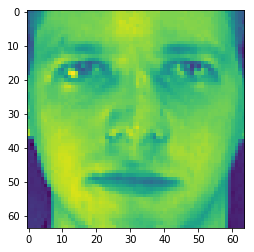

In [2]:
import tensorflow as tf
from sklearn.datasets import fetch_olivetti_faces
import random
import numpy as np
import matplotlib.pyplot as plt
import os

faces_all = fetch_olivetti_faces()
images = faces_all.images
plt.imshow(images[0:1].reshape((64,64)))
plt.show()

In [3]:
print(images.shape)
print(type(faces_all))
len_ = images.shape[0] * 0.75
type(len_)

(400, 64, 64)
<class 'sklearn.utils.Bunch'>


float

### Divider 만들기 


In [4]:
images = images.reshape([-1, 64 * 64])
print(images.shape)

# train data 와 Test data 을 나눕니다. 
def divide_train_test(dataset, train_ratio):
    # fix me #
    train_len = dataset.shape[0] * train_ratio
    train_len = int(train_len) # int cast for slicing
    return dataset[:train_len], dataset[train_len:]

# test 이미지와 train 이미지를 나눕니다. 전체 이미지에서 train image 의 비율은 75% 입니다. 
train_images, test_images = divide_train_test(images, train_ratio=0.75)
print('face train dataset shape: {}, test dataset shape : {}'.format(train_images.shape, test_images.shape))

(400, 4096)
face train dataset shape: (300, 4096), test dataset shape : (100, 4096)


In [5]:
# list 함수 작동 실험.. 
a = [[1,2,3],[4,5,6],[7,8,9]]
print(a)
print(a[:1][:])
del(a[:1])
print(a)

a = [0,1,2,3,4,5,6,7,8,9]
np.random.shuffle(a)
a

ind_ = [i for i in range(10)]
ind_

[[1, 2, 3], [4, 5, 6], [7, 8, 9]]
[[1, 2, 3]]
[[4, 5, 6], [7, 8, 9]]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

### DataProvider 만들기 


In [0]:
random.seed(0)
import copy
class DataProvider(object):
    def __init__(self, images):
        self.images = images
        self.images_fix = images # fix data저장
        self.len_ = self.images.shape[0] # 길이저장
        self.len_fix = copy.deepcopy(self.len_)  # fix길이 저장
        self.ind_range = self.images.shape[0] # index
        self.ind = [ x for x in range(self.ind_range)]
        np.random.shuffle(self.ind) # index shuffle
        self.images = self.images[self.ind, :] # shuffle 수행
        self.images = list(self.images) #list화 시킴(del() 등 list연산 사용필요)
        
    def next_batch(self, batch_size):
        #fix me#
        if self.len_ <= batch_size :
            ### 해당 epoch의 마지막 batch case ###
            # 1.나머지 모두 내보냄
            out_batch = self.images[:][:]
            del(self.images[:])
            
            # 2.다음 epoch의 shuffle 수행
            self.len_ = self.len_fix
            self.images = self.images_fix
            self.ind = [ x for x in range(self.ind_range)]
            np.random.shuffle(self.ind)
            self.images = self.images[self.ind, :]
            self.images = list(self.images)
            
        else : 
            # 일반 batch수행
            out_batch = self.images[:batch_size][:] # slice함
            del(self.images[:batch_size]) # 해당 배치만큼 data삭제
            self.len_ = self.len_ - batch_size # 길이줄임
            out_batch = np.array(out_batch)
        return out_batch

### Auto-Encoder 만들기 


In [7]:
g1 = tf.Graph()
# Input
xs = tf.placeholder(dtype = tf.float32, shape = [None,4096])
lr = tf.placeholder(dtype = tf.float32)
offset_place = tf.zeros(shape=(1,128), dtype=tf.float32)

he_init = tf.initializers.he_normal()

# Encoder
layer = xs
encode_units = [256, 256, 128]
encode1 = tf.layers.Dense(units=encode_units[0], activation=tf.nn.relu, kernel_initializer= he_init)(layer)
encode2 = tf.layers.Dense(units=encode_units[1], activation=tf.nn.relu, kernel_initializer= he_init)(encode1)
encode3 = tf.layers.Dense(units=encode_units[2], activation=tf.nn.relu, kernel_initializer= he_init)(encode2)

# Coding
code_unit = 128
code = tf.layers.Dense(units=code_unit, activation=tf.nn.tanh,
                       kernel_initializer=tf.initializers.glorot_normal(),
                      name='code')(encode3)

code_offset = code + offset_place
print(code.shape)

# Decoder
layer = code_offset
decode_units = encode_units[::-1] #역순
# except code units
#fix me#
decode1 = tf.layers.Dense(units=decode_units[0], activation=tf.nn.relu, kernel_initializer= he_init)(layer)
decode2 = tf.layers.Dense(units=decode_units[1], activation=tf.nn.relu, kernel_initializer= he_init)(decode1)
decode3 = tf.layers.Dense(units=decode_units[2], activation=tf.nn.relu, kernel_initializer= he_init)(decode2)

# Reconstruct
#fix me #
reconst = tf.layers.Dense(units=4096)(decode3)


# MSE Loss
#fix me#
mse = tf.reduce_mean((reconst - xs)**2)

# Adam Optimizer 
#fix me #
train_op = tf.train.AdamOptimizer(lr).minimize(mse)

Instructions for updating:
Colocations handled automatically by placer.
(?, 128)


In [34]:
# Saver
saver = tf.train.Saver()

# Session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training
batch_size = 40
n_epoch = 501
n_step = int(len(train_images) / batch_size)
lr_in = 0.0001

provider = DataProvider(train_images)
for e in range(n_epoch):
    for i in range(n_step):
        batch_xs = provider.next_batch(batch_size)
        
        # Training
        _ = sess.run(train_op, feed_dict = { xs : batch_xs, lr : lr_in})
        
        # 폴더를 생성합니다.  
        savedir = './reconstruct_images'
        os.makedirs(savedir, exist_ok=True)
    
    # Model save
    if e % 500 == 0 :
        saver.save(sess, './trained_model/' ,global_step=e)
    
    # epoch 이 한번 돌면 test loss 을 출력함.
    test_loss = sess.run(mse, feed_dict = {xs : test_images})
    print('epoch : {} , Loss : {}'.format(e ,test_loss))


    

epoch : 0 , Loss : 0.26083657145500183
epoch : 1 , Loss : 0.20533829927444458
epoch : 2 , Loss : 0.14317451417446136
epoch : 3 , Loss : 0.09208515286445618
epoch : 4 , Loss : 0.056834135204553604
epoch : 5 , Loss : 0.03741913661360741
epoch : 6 , Loss : 0.027956560254096985
epoch : 7 , Loss : 0.023460064083337784
epoch : 8 , Loss : 0.02158898301422596
epoch : 9 , Loss : 0.020029056817293167
epoch : 10 , Loss : 0.01945425197482109
epoch : 11 , Loss : 0.019072474911808968
epoch : 12 , Loss : 0.0191112719476223
epoch : 13 , Loss : 0.01863682270050049
epoch : 14 , Loss : 0.018494049087166786
epoch : 15 , Loss : 0.01823565550148487
epoch : 16 , Loss : 0.018105747178196907
epoch : 17 , Loss : 0.01807563751935959
epoch : 18 , Loss : 0.017755446955561638
epoch : 19 , Loss : 0.01771942898631096
epoch : 20 , Loss : 0.017523180693387985
epoch : 21 , Loss : 0.017587900161743164
epoch : 22 , Loss : 0.017519019544124603
epoch : 23 , Loss : 0.017725462093949318
epoch : 24 , Loss : 0.01762173697352409

### Change face 만들기 

학습된 코딩 부분을 변형해 얼굴이 어떻게 변화하는지 살펴 봅니다.
![Imgur](https://i.imgur.com/Ehc5Miw.png)

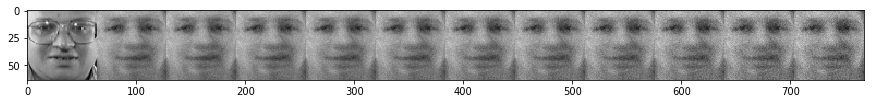

In [23]:
# code의 output에 offest을 더해서 움직임 (w,b아님)
# 모델을 그대로 사용함 코드뒤로 잘라서 사용하지 않음
# code에 offset 을 추가
sample = test_images[1:2]
offset = [0.]*128 #np.zeros(shape=(128,), dtype=np.float32)

# 복원된 이미지가 저장됩니다.
offset_images = []

# offset vector 의 element 는 모두 0 입니다. 
# offset vector 에 특정 element 에 0.1 씩 더한후 결과를 다시 코드(code)에 주입합니다.
# 코드에 주입한 후 reconstruct 된 결과를 offset_images 에 저장합니다. 
offset_number = 3
for i in np.arange(0, 1, 0.1):
    offset[offset_number] = i
    offset_ = np.reshape(offset, (-1,128))
    recon_noise = sess.run(reconst, feed_dict = { xs : sample,
                                    offset_place : offset_})
    recon_noise_img =  np.reshape(recon_noise, (64,64)) 
    offset_images.append(recon_noise_img)

# 이미지를 가로로 붙여 한장의 이미지로 만듭니다. 
merged_images = np.concatenate([offset_images[i] for i in range(0,10)], axis = 1)

# 가장 왼쪽부터 original image, reconstruct image ,offset 에 0.1 씩 더해진 이미지를 
# 한장의 이미지로 만듭니다. 
sample_img = np.concatenate([sample.reshape(64,64), sess.run(reconst, feed_dict = { xs : sample}).reshape(64,64), merged_images], axis = 1)
faces = sample_img
plt.figure(figsize=(15,10))
plt.imshow(faces, cmap='gray')

### 자신의 얼굴 변형해보기

자신의 얼굴  auto encoder 에 넣고 복원된 결과를 확인해 봅니다. 


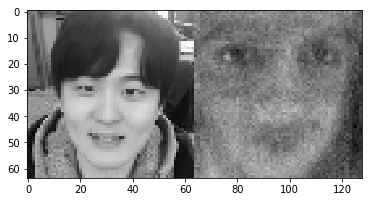

In [40]:
#파일명은 myface.jpeg 로 넣어주세요. 

import cv2
# image 을 읽어오고
my_img = cv2.imread('my_face.jpg')
#컬러사진을 흑백사진으로 바꿉니다. 
my_img = cv2.cvtColor(my_img, cv2.COLOR_BGR2GRAY)
# 이미지 size 을 조절합니다. 
my_img_gray=cv2.resize(my_img,(64,64))

offset = [0.]*128
offset_ = np.reshape(offset, (-1,128))

# pixel 값의 범위가 0~1 사이가 되도록 normalize 합니다. 
my_gray = my_img_gray / 255.

# 이미지를 auto encoder 에 넣을수 있도록 한줄로 핍니다. 
my_flat = np.reshape(my_gray,(1,-1))

# auto encoder 에서 복원된 이미지를 가져옵니다. 
recon_noise = sess.run(reconst, feed_dict = { xs : my_flat,
                                offset_place : offset_})
my_recon = recon_noise
my_recon = my_recon.reshape(64,64)
# original 사진과 복원된 이미지를 붙여 한장의 사진으로 만듭니다. 
faces = np.concatenate([my_gray,my_recon], axis = 1)
plt.imshow(faces, cmap='gray')

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/03/22

---